# Vacamole

This example is taken from the documentation of the R package
[`epidemics`](https://raw.githubusercontent.com/epiverse-trace/epidemics/main/vignettes/vacamole.Rmd).

In [ ]:
library(epidemics)
library(data.table)
library(ggplot2)
library(colorspace)
library(scales)

## Prepare population and initial conditions

Prepare population and contact data.

In [ ]:
# load contact and population data from socialmixr::polymod
polymod <- socialmixr::polymod
contact_data <- socialmixr::contact_matrix(
  polymod,
  countries = "United Kingdom",
  age.limits = c(0, 20, 65),
  symmetric = TRUE
)

Using POLYMOD social contact data. To cite this in a publication, use the 'cite' function

Removing participants that have contacts without age information. To change this behaviour, set the 'missing.contact.age' option

Prepare initial conditions for each age group. The Vacamole model has 11
compartments and therefore requires a matrix with 11 columns.

In [ ]:
# initial conditions
initial_i <- 1e-6

# // 0| 1| 2|3| 4|5| 6|7| 8|9|10
# // S|V1|V2|E|EV|I|IV|H|HV|D|R

# make initial conditions - order is important
initial_conditions <- c(
  S = 1 - initial_i,
  V1 = 0, V2 = 0,
  E = 0, EV = 0,
  I = initial_i, IV = 0,
  H = 0, HV = 0, D = 0, R = 0
)
initial_conditions <- rbind(
  initial_conditions,
  initial_conditions,
  initial_conditions
)

# assign rownames for clarity
rownames(initial_conditions) <- rownames(contact_matrix)

Prepare the time in days over which to model the epidemic, with the
outbreak beginning at day zero.

In [ ]:
epidemic_days <- 300

Prepare a population as a `population` class object.

In [ ]:
uk_population <- population(
  name = "UK",
  contact_matrix = contact_matrix,
  demography_vector = demography_vector,
  initial_conditions = initial_conditions
)

## Prepare pathogen parameters

In [ ]:
# make infection class for Vacamole model
# note extra arguments passed as ...
infect <- infection(
  name = "covid", r0 = 3, infectious_period = 10,
  preinfectious_period = 5,
  eta = 1 / 1000, omega = 1 / 1000,
  susc_reduction_vax = 0.5,
  hosp_reduction_vax = 0.5,
  mort_reduction_vax = 0.5
)

## Prepare a two dose vaccination campaign

We prepare a two-dose vaccination campaign by concatenating two single
dose vaccination regimes, i.e., applying the function `c()` to two
`vaccination` objects.

In [ ]:
# prepare a two dose vaccination regime for a single age group
# prepare the first dose
dose_1 <- vaccination(
  name = "two-dose vaccination", # name given to first dose
  nu = matrix(1e-2, nrow = 3),
  time_begin = matrix(30, nrow = 3),
  time_end = matrix(epidemic_days, nrow = 3)
)

# prepare the second dose with a 30 day interval in start date
dose_2 <- vaccination(
  name = "two-dose vaccination", # name given to first dose
  nu = matrix(1e-2, nrow = 3),
  time_begin = matrix(60, nrow = 3),
  time_end = matrix(epidemic_days, nrow = 3)
)

# use `c()` to combine the two doses
double_vaccination <- c(dose_1, dose_2)

# print to visualise
double_vaccination

<vaccination>
Vaccination name: "two-dose vaccination"

Time begin:
     dose_1 dose_2
[1,]     30     60
[2,]     30     60
[3,]     30     60

Time end:
     dose_1 dose_2
[1,]    300    300
[2,]    300    300
[3,]    300    300

Vaccination rate:
     dose_1 dose_2
[1,]   0.01   0.01
[2,]   0.01   0.01
[3,]   0.01   0.01

We prepare a dummy vaccination regime of no vaccination against which to
compare the two-dose vaccination campaign. This is done by using the
`no_vaccination()` function and specifying the number of doses (here, 2
doses).

In [ ]:
# prepare a null vaccination regime with two doses
# use the convenience function `no_vaccination()`
no_vaccination <- no_vaccination(population = uk_population, doses = 2)

## Model epidemic using Vacamole

First, we run the model with no vaccination.

In [ ]:
data <- epidemic(
  model_name = "vacamole",
  population = uk_population,
  infection = infect,
  vaccination = no_vaccination, # note custom no_vaccination object
  time_end = epidemic_days
)

Next we run the model with a two dose vaccination regime.

In [ ]:
data_vaccination <- epidemic(
  model_name = "vacamole",
  population = uk_population,
  infection = infect,
  vaccination = double_vaccination, # note custom object for two doses
  time_end = epidemic_days
)

## Visualise model outcomes

First, we calculate the total number of infections resulting in
recoveries and deaths over the course of the simulation; this is the
epidemic’s final size.

In [ ]:
# collect data from the two scenarios
data_scenarios <- list(data, data_vaccination)

# get deaths and recoveries from infection
data_scenarios <- Map(
  data_scenarios, c("no_vax", "vax"),
  f = function(df, sc) {
    df_ <- unique(df[, "demography_group"], by = "demography_group")
    # get total deaths per group
    df_$total_deaths <- df[time == max(time) & compartment == "dead", ]$value

    # get total recoveries per group using helper function `epidemic_size()`
    df_$total_recovered <- epidemic_size(df, deaths = FALSE) # do not count dead

    # add scenario information
    df_$scenario <- sc

    # return data
    df_
  }
)

# collect data
data_scenarios <- rbindlist(data_scenarios)

# transform to long format
data_scenarios <- melt(
  data_scenarios,
  id.vars = c("demography_group", "scenario")
)

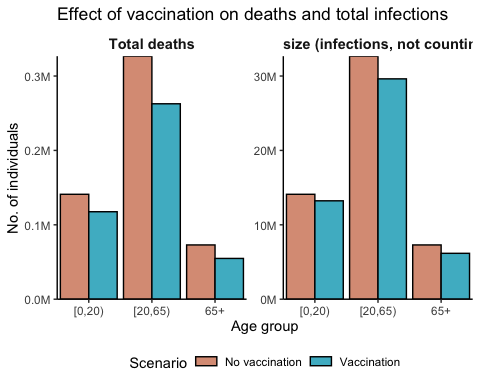

In [ ]:
ggplot(data_scenarios) +
  geom_col(
    aes(demography_group, value, fill = scenario),
    position = "dodge",
    colour = "black"
  ) +
  facet_wrap(
    ~variable,
    scales = "free_y",
    labeller = labeller(
      variable = c(
        "total_deaths" = "Total deaths",
        "total_recovered" = "Epidemic size (infections, not counting deaths)"
      )
    )
  ) +
  scale_fill_discrete_qualitative(
    palette = "Dynamic",
    labels = c("No vaccination", "Vaccination"),
    name = "Scenario",
    na.value = "lightgrey"
  ) +
  scale_y_continuous(
    labels = label_comma(
      scale = 1e-6, suffix = "M"
    )
  ) +
  theme_classic() +
  theme(
    legend.position = "bottom",
    legend.key.height = unit(2, "mm"),
    strip.background = element_blank(),
    strip.text = element_text(
      face = "bold",
      size = 11
    )
  ) +
  expand_limits(
    x = c(0.5, length(unique(data_scenarios$demography_group)) + 0.5)
  ) +
  coord_cartesian(
    expand = FALSE
  ) +
  labs(
    x = "Age group",
    y = "No. of individuals",
    title = "Effect of vaccination on deaths and total infections"
  )

Finally, we can compare the peak of hospital bed occupancy in each
scenario — this can be a rough indication of how much hospital capacity
would be required if a pandemic of these characteristics were to occur,
as well as another way to examine the effect of vaccination in reducing
this requirement.

In [ ]:
# collect data from the two scenarios
data_scenarios <- list(data, data_vaccination)

peak_hospital_occupancy <- vapply(data_scenarios, function(df) {
  # get highest hospital occupancy
  # first get total hospitalisations among vaccinated and un- or part-vacc.
  df <- dcast(
    df[compartment %like% "hospitalised", ],
    time + demography_group ~ compartment,
    value.var = "value"
  )
  df[, total_hosp := hospitalised + hospitalised_vaccinated]

  # sum all age groups
  df <- df[, list(total_hosp = sum(total_hosp)), by = "time"]

  df[total_hosp == max(total_hosp), ]$total_hosp
}, FUN.VALUE = numeric(1))

# set names for comprehensibility
names(peak_hospital_occupancy) <- c("No vaccination", "Vaccination")

# show peak hospital occupancy in a readable format
format(peak_hospital_occupancy, big.mark = ",", digits = 1)

No vaccination    Vaccination 
      "95,063"       "69,827" 

This example demonstrates that implementing vaccination can
substantially reduce peak hospital occupancy (by about 27%) compared to
a scenario in which no vaccines are deployed.